In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from time import time
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
from scipy.stats import f
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.stattools import adfuller, kpss
import pmdarima as pm
from pmdarima import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor


In [2]:
#  Read the data and derive information about it
data = pd.read_excel('data_name_aqi.xlsx')
data.info()
data.describe()
# Calculate missing values
missing_count = data.isnull().sum()
missing_percentage = data.isnull().mean() * 100 
valid_counts = data.notnull().sum()
missing_stats = pd.DataFrame({
    'Missing Count': missing_count, 
    'Missing Percentage': missing_percentage, 
    'Valid Counts': valid_counts
})
missing_stats

data.interpolate(method='linear', inplace=True)


for column in data.columns:
    if pd.isnull(data[column].iloc[0]):
        data[column].iloc[0] = data[column].bfill().iloc[0]
    if pd.isnull(data[column].iloc[-1]):
        data[column].iloc[-1] = data[column].ffill().iloc[-1]
        # Check for missing values
missing_count = data.isnull().sum()
print (missing_count)
# Ensure 'date' is in datetime format and sort by date
data['date'] = pd.to_datetime(data['date'])
data.sort_values('date', inplace=True)

# Check initial data shape
initial_shape = data.shape[0]

# Use shift to create the target column for next day's AQI
data['Next_Day_AQI'] = data['AQI'].shift(-1)

# Check how many rows will have NaN in 'Next_Day_AQI' (should be only the last one)
nan_in_target = data['Next_Day_AQI'].isna().sum()

# Drop the rows where 'Next_Day_AQI' is NaN (typically just the last row)
data.dropna(subset=['Next_Day_AQI'], inplace=True)

# Final data shape after dropping NaN in 'Next_Day_AQI'
final_shape = data.shape[0]

# Output the initial and final data shapes and the count of NaN in 'Next_Day_AQI'
initial_shape, final_shape, nan_in_target
data.describe()
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1461 non-null   datetime64[ns]
 1   temperature           1452 non-null   float64       
 2   atmospheric_pressure  1452 non-null   float64       
 3   relative_humidity     1452 non-null   float64       
 4   precipitation         1461 non-null   float64       
 5   wind_speed            1452 non-null   float64       
 6   CO                    1461 non-null   float64       
 7   NO2                   1461 non-null   int64         
 8   O3                    1461 non-null   int64         
 9   PM10                  1461 non-null   int64         
 10  PM2.5                 1461 non-null   int64         
 11  SO2                   1461 non-null   int64         
 12  AQI                   1461 non-null   int64         
dtypes: datetime64[ns](

In [3]:
print(data.head(7))
data.info

        date  temperature  atmospheric_pressure  relative_humidity  \
0 2020-01-01         -6.4                1028.2               39.0   
1 2020-01-02         -3.8                1027.3               43.0   
2 2020-01-03         -1.9                1025.0               50.0   
3 2020-01-04         -0.1                1024.4               48.0   
4 2020-01-05         -1.1                1027.2               75.0   
5 2020-01-06          0.3                1022.1               87.0   
6 2020-01-07          1.1                1021.7               39.0   

   precipitation  wind_speed    CO  NO2  O3  PM10  PM2.5  SO2  AQI  \
0            0.0         1.3  0.79   49  10    55     34    7   52   
1            0.0         1.0  1.18   63   9    79     51    7   70   
2            0.0         1.4  1.20   64  14    72     51    8   70   
3            0.0         1.0  1.08   59  21    66     42    7   61   
4            0.6         1.5  1.39   66   7    79     64    7   86   
5            4.1   

<bound method DataFrame.info of            date  temperature  atmospheric_pressure  relative_humidity  \
0    2020-01-01         -6.4                1028.2               39.0   
1    2020-01-02         -3.8                1027.3               43.0   
2    2020-01-03         -1.9                1025.0               50.0   
3    2020-01-04         -0.1                1024.4               48.0   
4    2020-01-05         -1.1                1027.2               75.0   
...         ...          ...                   ...                ...   
1455 2023-12-26         -2.4                1026.8               56.0   
1456 2023-12-27         -4.5                1029.0               69.0   
1457 2023-12-28         -3.5                1025.4               72.0   
1458 2023-12-29         -3.2                1020.6               78.0   
1459 2023-12-30         -2.0                1013.3               80.0   

      precipitation  wind_speed    CO  NO2  O3  PM10  PM2.5  SO2  AQI  \
0               0.

# 11-radom forest

In [4]:
# Ensure 'date' is in datetime format and sort by date
data['date'] = pd.to_datetime(data['date'])
data.sort_values('date', inplace=True)

# Set 'date' as the index
data.set_index('date', inplace=True)

1095
            temperature  atmospheric_pressure  relative_humidity  \
date                                                               
2022-12-31         -3.3                1026.7               42.0   
2023-01-01         -3.4                1031.4               47.0   
2023-01-02         -2.1                1033.1               35.0   
2023-01-03         -3.7                1027.9               39.0   
2023-01-04         -3.1                1026.7               50.0   
...                 ...                   ...                ...   
2023-12-26         -2.4                1026.8               56.0   
2023-12-27         -4.5                1029.0               69.0   
2023-12-28         -3.5                1025.4               72.0   
2023-12-29         -3.2                1020.6               78.0   
2023-12-30         -2.0                1013.3               80.0   

            precipitation  wind_speed    CO  NO2  O3  PM10  PM2.5  SO2  AQI  \
date                           

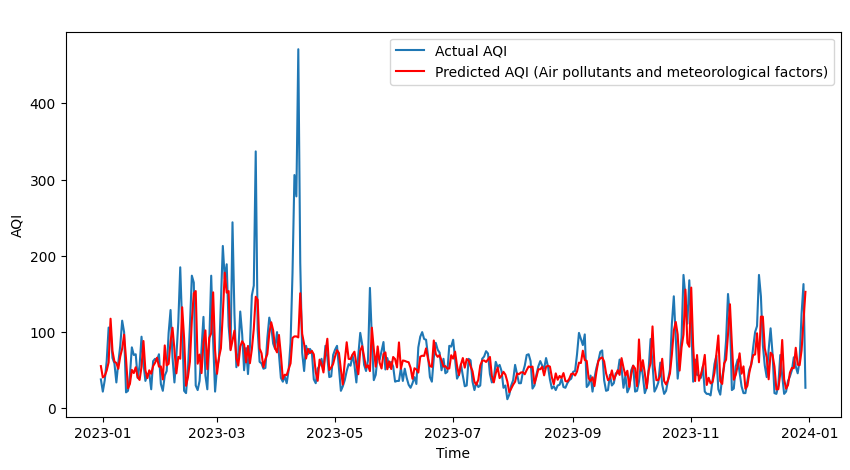

In [5]:

split_point = int(len(data) * 0.75)
print(split_point)

train_data = data.iloc[:split_point]
test_data = data.iloc[split_point:]
print(test_data)

train_x = train_data.drop(['AQI', 'Next_Day_AQI'], axis=1)
train_y = train_data['Next_Day_AQI']
test_x = test_data.drop(['AQI',  'Next_Day_AQI'], axis=1)
test_y = test_data['Next_Day_AQI']
print(train_x.columns)

# a CART using default settings
cart_default = DecisionTreeRegressor(random_state=0)
cart_default.fit(train_x, train_y)
# print the tree depth
print("Tree depth: {}".format(cart_default.get_depth()))

hyperparameters = {'max_depth': [10, 20, 30, 40, 50], 'min_samples_split': [2, 4, 6, 8, 10]}


randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)
clf = GridSearchCV(rf, hyperparameters, cv=5) 


clf.fit(train_x, train_y)
print("The best parameter value is: ", clf.best_params_)
print("The best score is: ", clf.best_score_)


rf_final = RandomForestRegressor(**clf.best_params_, random_state=randomState_dt)
rf_final.fit(train_x, train_y)


predictions1 = rf_final.predict(test_x)

plt.figure(figsize=(10, 5))
plt.plot(test_y.index, test_y.values, label='Actual AQI')
plt.plot(test_y.index, predictions1, label='Predicted AQI (Air pollutants and meteorological factors)', color='red',  marker='')
plt.title(' ')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.legend()

output_path = 'C:/Users/Liu/Downloads/8_dissertation/rf_11.png'
plt.savefig(output_path)
plt.show()

In [6]:
print("R2 on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

print("RMSE on the testing data:")
print(mean_squared_error(test_y, rf_final.predict(test_x), squared=False))

from sklearn.metrics import mean_squared_error, mean_absolute_error
print("MSE on the testing data:")
print(mean_squared_error(test_y, rf_final.predict(test_x)))
print("MAE on the testing data:")
print(mean_absolute_error(test_y, rf_final.predict(test_x)))

R2 on the testing data:
0.3235990049330405
RMSE on the testing data:
39.8750225832711
MSE on the testing data:
1590.01742601638
MAE on the testing data:
23.15947981989197


E:\python\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


                      Importance
Feature                         
PM2.5                   0.356812
PM10                    0.107759
NO2                     0.080210
atmospheric_pressure    0.014723
O3                      0.011994
relative_humidity       0.006810
wind_speed              0.005482
precipitation          -0.001987
SO2                    -0.002095
temperature            -0.004468
CO                     -0.012234


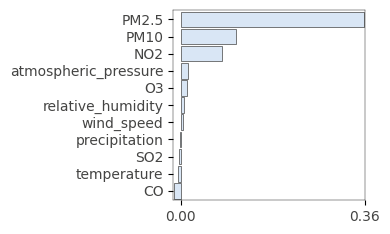

In [7]:
import rfpimp
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

# 6_random forest

In [8]:

train_x6 = train_data.drop(['AQI', 'Next_Day_AQI','temperature', 'atmospheric_pressure', 'relative_humidity',
       'precipitation', 'wind_speed'], axis=1)
train_y6 = train_data['Next_Day_AQI']
test_x6 = test_data.drop(['AQI',  'Next_Day_AQI','temperature', 'atmospheric_pressure', 'relative_humidity',
       'precipitation', 'wind_speed'], axis=1)
test_y6 = test_data['Next_Day_AQI']
print(train_x6.columns)

Index(['CO', 'NO2', 'O3', 'PM10', 'PM2.5', 'SO2'], dtype='object')


In [9]:

hyperparameters = {'max_depth': [10, 20, 30, 40, 50], 'min_samples_split': [2, 4, 6, 8, 10]}


randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)
clf = GridSearchCV(rf, hyperparameters, cv=5) 


clf.fit(train_x6, train_y6)
print("The best parameter value is: ", clf.best_params_)
print("The best score is: ", clf.best_score_)


rf_final6 = RandomForestRegressor(**clf.best_params_, random_state=randomState_dt)
rf_final6.fit(train_x6, train_y6)


predictions2 = rf_final6.predict(test_x6)


The best parameter value is:  {'max_depth': 10, 'min_samples_split': 10}
The best score is:  0.3466685359996635


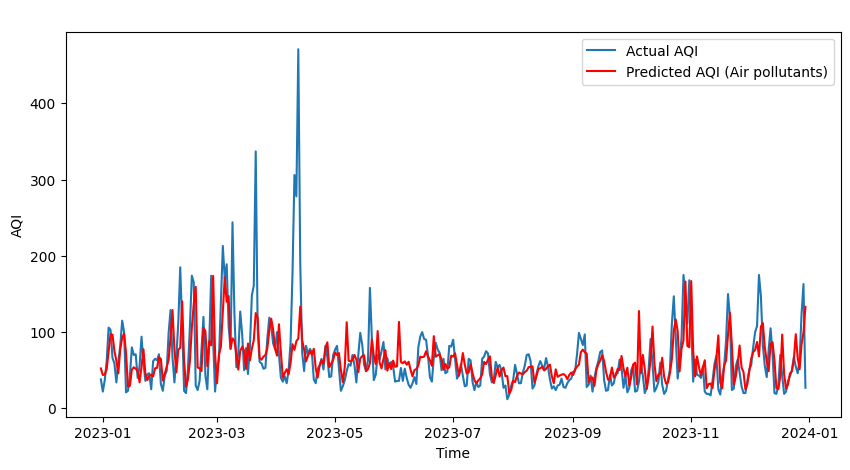

In [10]:

plt.figure(figsize=(10, 5))
plt.plot(test_y6.index, test_y6.values, label='Actual AQI')
plt.plot(test_y6.index, predictions2, label='Predicted AQI (Air pollutants)', color='red',  marker='')
plt.title(' ')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.legend()

output_path = 'C:/Users/Liu/Downloads/8_dissertation/rf_6.png'
plt.savefig(output_path)
plt.show()

In [11]:
print("R2 on the testing data:")
print(rf_final6.score(X=test_x6, y=test_y6))

print("RMSE on the testing data:")
print(mean_squared_error(test_y6, rf_final6.predict(test_x6), squared=False))

print("MSE on the testing data:")
print(mean_squared_error(test_y6, rf_final6.predict(test_x6)))
print("MAE on the testing data:")
print(mean_absolute_error(test_y6, rf_final6.predict(test_x6)))

R2 on the testing data:
0.28098777949056875
RMSE on the testing data:
41.11184421665665
MSE on the testing data:
1690.1837348946447
MAE on the testing data:
23.98530893466368


E:\python\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


         Importance
Feature            
PM2.5      0.236839
NO2        0.146221
PM10       0.111951
O3         0.023631
CO         0.013976
SO2       -0.005650


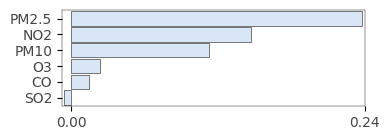

In [12]:
import rfpimp
imp = rfpimp.importances(rf_final6, test_x6, test_y6)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

# 5_random foreat

In [13]:

train_x = train_data.drop(['AQI', 'Next_Day_AQI','CO', 'NO2', 'O3', 'PM10', 'PM2.5',
       'SO2'], axis=1)
train_y = train_data['Next_Day_AQI']
test_x = test_data.drop(['AQI','Next_Day_AQI','CO', 'NO2', 'O3', 'PM10', 'PM2.5',
       'SO2'], axis=1)
test_y = test_data['Next_Day_AQI']
print(train_x.columns)

Index(['temperature', 'atmospheric_pressure', 'relative_humidity',
       'precipitation', 'wind_speed'],
      dtype='object')


In [14]:

hyperparameters = {'max_depth': [10, 20, 30, 40, 50], 'min_samples_split': [2, 4, 6, 8, 10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)
clf = GridSearchCV(rf, hyperparameters, cv=5)  

clf.fit(train_x, train_y)
print("The best parameter value is: ", clf.best_params_)
print("The best score is: ", clf.best_score_)

rf_final = RandomForestRegressor(**clf.best_params_, random_state=randomState_dt)
rf_final.fit(train_x, train_y)

predictions3 = rf_final.predict(test_x)

The best parameter value is:  {'max_depth': 10, 'min_samples_split': 10}
The best score is:  0.044369902061712874


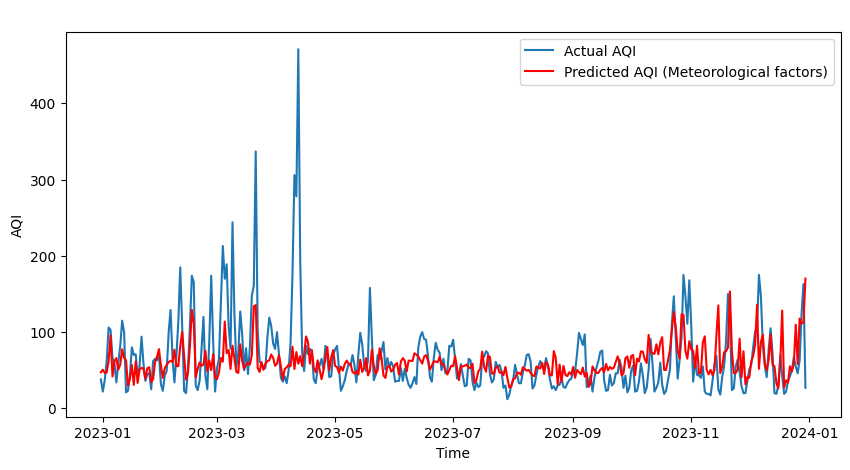

In [15]:

plt.figure(figsize=(10, 5))
plt.plot(test_y.index,test_y.values, label='Actual AQI')
plt.plot(test_y.index,predictions3, label='Predicted AQI (Meteorological factors)', color='red',  marker=' ')
plt.title(' ')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.legend()

output_path = 'C:/Users/Liu/Downloads/8_dissertation/rf_5.png'
plt.savefig(output_path)
plt.show()

In [16]:
print("R2 on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

print("RMSE on the testing data:")
print(mean_squared_error(test_y, rf_final.predict(test_x), squared=False))

print("MSE on the testing data:")
print(mean_squared_error(test_y, rf_final.predict(test_x)))
print("MAE on the testing data:")
print(mean_absolute_error(test_y, rf_final.predict(test_x)))

R2 on the testing data:
0.13913239717962578
RMSE on the testing data:
44.984925465048924
MSE on the testing data:
2023.643519096007
MAE on the testing data:
26.781908065744094


E:\python\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


                      Importance
Feature                         
temperature             0.360482
atmospheric_pressure    0.099687
wind_speed              0.044340
precipitation           0.027122
relative_humidity       0.024825


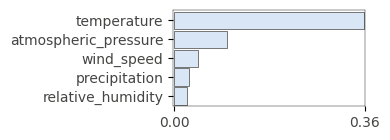

In [17]:
import rfpimp
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

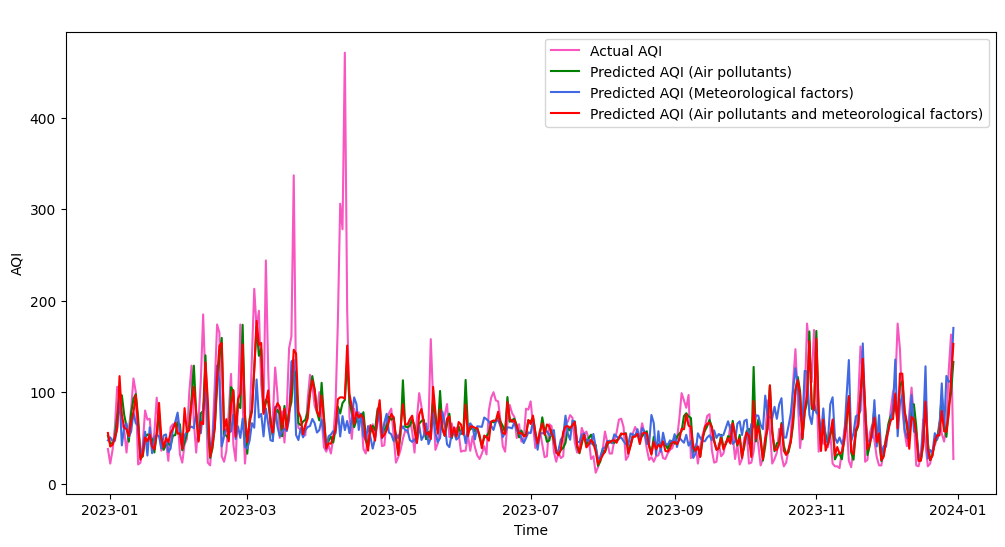

In [18]:

plt.figure(figsize=(12, 6))

plt.plot(test_y6.index, test_y6.values, label='Actual AQI',color='#F857C1')

plt.plot(test_y6.index, predictions2, label='Predicted AQI (Air pollutants)', color='green', marker='')
plt.plot(test_y6.index, predictions3, label='Predicted AQI (Meteorological factors)', color='royalblue', marker='')
plt.plot(test_y6.index, predictions1, label='Predicted AQI (Air pollutants and meteorological factors)', color='red', marker='')

plt.title(' ')
plt.xlabel('Time')
plt.ylabel('AQI')

plt.legend()

output_path = 'C:/Users/Liu/Downloads/8_dissertation/rf_3.png'
plt.savefig(output_path)

plt.show()


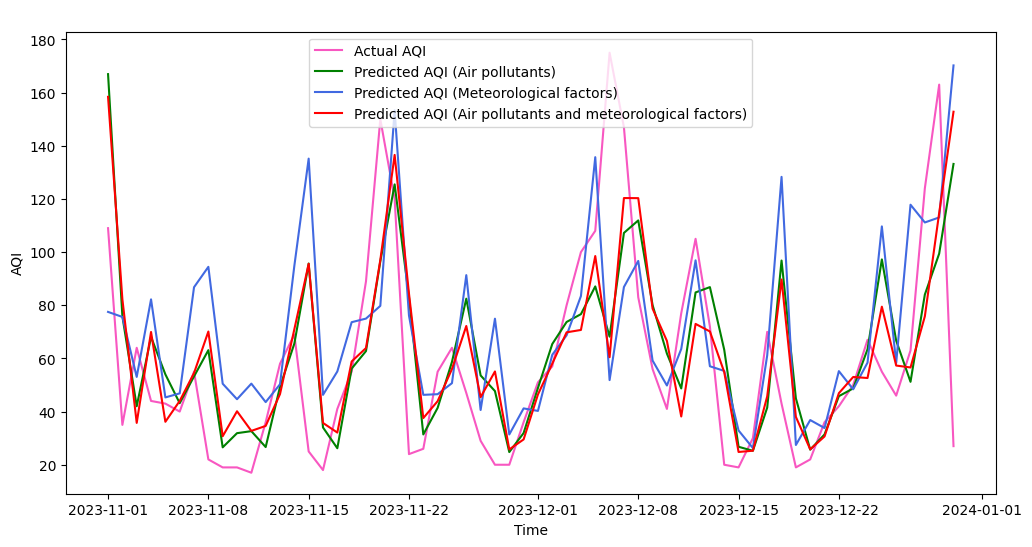

In [19]:

last_30_days = 60
test_y6_last_30 = test_y6[-last_30_days:]
predictions1_last_30 = predictions1[-last_30_days:]
predictions2_last_30 = predictions2[-last_30_days:]
predictions3_last_30 = predictions3[-last_30_days:]

plt.figure(figsize=(12, 6))

plt.plot(test_y6_last_30.index, test_y6_last_30.values, label='Actual AQI', color='#F857C1')

plt.plot(test_y6_last_30.index, predictions2_last_30, label='Predicted AQI (Air pollutants)', color='green', marker='')
plt.plot(test_y6_last_30.index, predictions3_last_30, label='Predicted AQI (Meteorological factors)', color='royalblue', marker='')
plt.plot(test_y6_last_30.index, predictions1_last_30, label='Predicted AQI (Air pollutants and meteorological factors)', color='red', marker='')

plt.title(' ')
plt.xlabel('Time')
plt.ylabel('AQI')

plt.legend()

output_path = 'C:/Users/Liu/Downloads/8_dissertation/rf_3_last_30_days.png'
plt.savefig(output_path)

plt.show()